# **Variational AutoEncoder trained on MNIST**

## Import libraries

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import pickle

## Hyper parameters

In [ ]:
batch_size = 64
test_batch_size = 1000
seed = 1
lr = 0.001
no_cuda = False
eps = 10
z_dim = 2
drop_prob = 0.25

use_cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

print("Device:", end=" ")
print(device)

Device: cuda


## Prepare data loader for training and testing

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_data = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('../data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


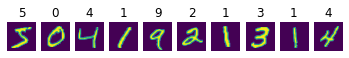

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

for i in range(10):
  train_x = train_data.data[i]
  train_y = train_data.targets[i]

  ax = fig.add_subplot(1, 10, i+1)
  ax.imshow(train_x)
  ax.set_title(str(train_y.item()))
  ax.axis("off")

plt.show()

## Gaussian MLP as encoder

In [ ]:
class gaussian_MLP_encoder(nn.Module):
  def __init__(self, h1=500, h2=500, n_output=2, drop_prob=0.9):
    super(gaussian_MLP_encoder, self).__init__()
    self.fc1 = nn.Linear(784, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc_mean = nn.Linear(h2, n_output)
    self.fc_stddev = nn.Linear(h2, n_output)
    self.drop_prob = drop_prob

  def reparametrize(self, mu, logvar):
    std = (logvar.exp_()).mul(0.5)
    eps = torch.FloatTensor(std.size()).normal_()
    eps = Variable(eps).cuda()
    return eps.mul(std).add_(mu)

  def forward(self, x):
    x = F.dropout(F.elu(self.fc1(x.view(-1, 784))), p=self.drop_prob)
    x = F.dropout(torch.tanh(self.fc2(x)), p=self.drop_prob)
    mean = self.fc_mean(x)     # mean
    stddev = self.fc_stddev(x) # log(var)
    rp = self.reparametrize(mean, stddev)
    return mean, stddev, rp

## Bernoulli MLP as decoder

In [ ]:
class bernoulli_MLP_decoder(nn.Module):
  def __init__(self, h1=500, h2=500, n_input=2, drop_prob=0.9):
    super(bernoulli_MLP_decoder, self).__init__()
    self.fc1 = nn.Linear(n_input, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, 784)
    self.drop_prob = drop_prob

  def forward(self, x):
    x = F.dropout(torch.tanh(self.fc1(x)), p=self.drop_prob)
    x = F.dropout(F.elu(self.fc2(x)), p=self.drop_prob)
    x = torch.sigmoid(self.fc3(x))
    return x.view(-1, 1, 28, 28)

## Loss function

In [ ]:
encoder = gaussian_MLP_encoder(n_output=z_dim, drop_prob=drop_prob).cuda()
decoder = bernoulli_MLP_decoder(n_input=z_dim, drop_prob=drop_prob).cuda()
parameters = list(encoder.parameters())+ list(decoder.parameters())
optimizer = optim.Adam(parameters, lr=lr)

def loss_function(recon_x, x, mu, logvar):
  BCE = nn.functional.binary_cross_entropy(recon_x, x, size_average=False) / batch_size
  KLD = torch.mean(0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1. - logvar, 1))

  return BCE + KLD

## Train

In [ ]:
encoder.train()
decoder.train()

batches, losses = [], []
for ep in range(eps):
  print("============= Epoch %d =============" % (ep+1))
  for batch_idx, (image, y) in enumerate(train_loader):
    optimizer.zero_grad()

    image = Variable(image).cuda()
    mu, log_var, reparam = encoder(image)
    output = decoder(reparam)
    
    loss = loss_function(output, image, mu, log_var)
    loss.backward()
    optimizer.step()

    if batch_idx % 100 == 99:
      print("%d: loss = %f" % ((batch_idx+1), loss))
    
  losses.append(loss.cpu().data.numpy())

plt.plot(losses)
plt.show()

## Check last output images

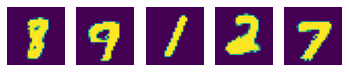

In [ ]:
out_img = torch.squeeze(output.cpu().data)
n_out = 5

fig = plt.figure()

for i in range(n_out):
  train_x = train_data.data[i]
  train_y = train_data.targets[i]

  ax = fig.add_subplot(1, n_out, i+1)
  ax.imshow(out_img[i].numpy())
  ax.axis("off")

plt.show()

## Test

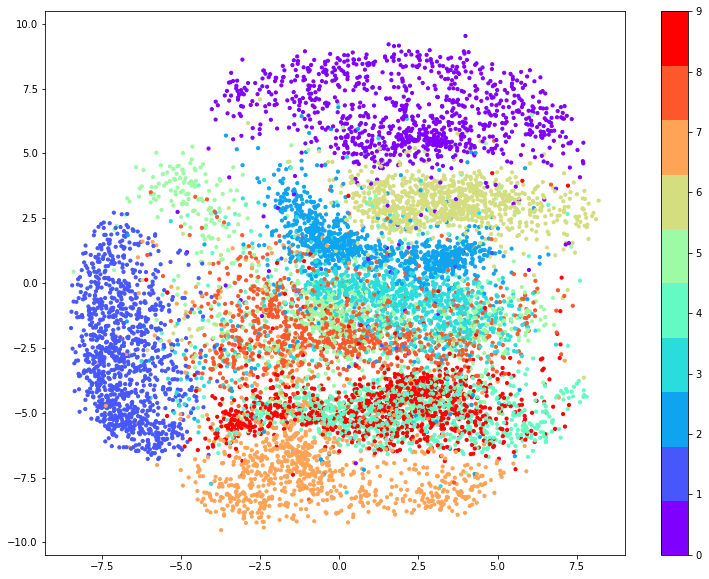

In [ ]:
encoder.eval()
decoder.eval()

outputs, x, y, z = [], [], [], []

for batch_idx, (image, label) in enumerate(test_loader):

  image = Variable(image).cuda()
  mu, log_var, reparam = encoder(image)
  output = decoder(reparam)
  
  for i in range(test_batch_size):
    if i % 1 == 0:
      x.append(reparam[i][0].cpu().data.numpy())
      y.append(reparam[i][1].cpu().data.numpy())
      z.append(label[i].cpu().data.numpy())
  outputs.append(output)

plt.figure(figsize=(13,10))
plt.scatter(x, y, c=z, s=10, cmap=plt.cm.get_cmap('rainbow', 10))
plt.colorbar()

## Check reconstruction with last output images

torch.Size([1000, 28, 28])


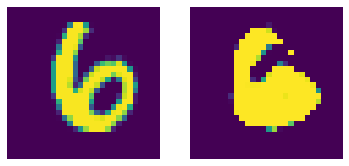

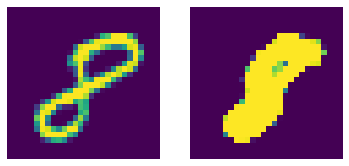

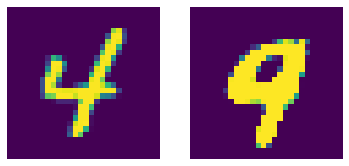

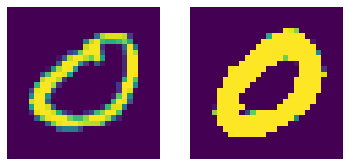

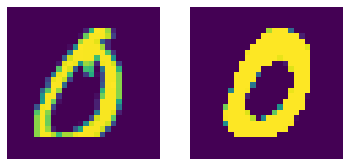

In [ ]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(torch.squeeze(image[i].cpu()).data.numpy())
  ax.axis("off")
  ax = fig.add_subplot(1, 2, 2)
  ax.imshow(out_img[i].numpy())
  ax.axis("off")
  plt.show()

## Make New Handwritting Digits by Decoder (z_dim=2)

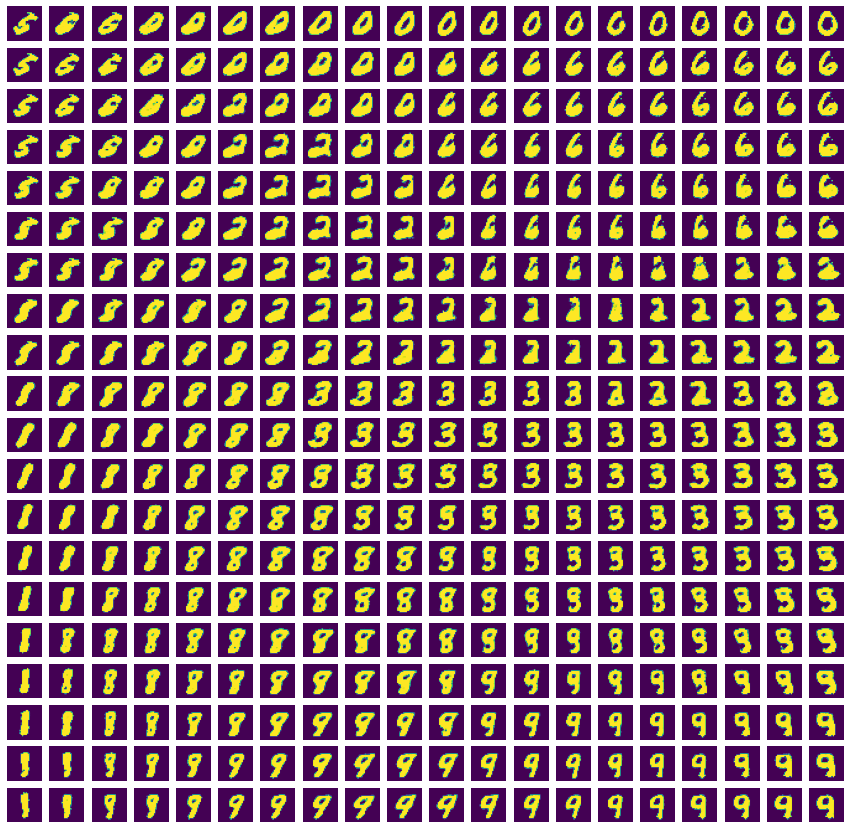

In [ ]:
fig = plt.figure(figsize=(15,15))

size = 20

for j in range(size):
  for i in range(size):
    z = [(5+10*i)/size-5, 5-(5+10*j)/size]
    z = torch.FloatTensor(z).cuda()
    output = decoder(z)
    ax = fig.add_subplot(size, size, i+1+size*j)
    ax.imshow(torch.squeeze(output.cpu()).data.numpy(), cmap="gray")
    ax.axis("off")